# Twitter Sentiment Analysis

## Introduction
In this notebook, I will analyze 20,000 tweets randomly sampled from the Sentiment140 dataset, which contains 1.6 million tweets labeled positive or negative.  
The goal is to build a simple machine learning model that can classify tweets based on sentiment.  

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sampa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sampa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
#load the dataset
df = pd.read_csv('sentiment140_sample.csv', encoding='latin-1', header=0)
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']
# negative: 0, positive: 1
df['target'] = df['target'].replace({0: 0, 4: 1})

df.head()


,target,id,date,flag,user,text
0,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
1,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
2,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
3,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
4,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem


In [15]:
# Keep only the necessary columns
df = df[['target', 'text']]
df.head()

,target,text
0,0,@chrishasboobs AHHH I HOPE YOUR OK!!!
1,0,"@misstoriblack cool , i have no tweet apps fo..."
2,0,@TiannaChaos i know just family drama. its la...
3,0,School email won't open and I have geography ...
4,0,upper airways problem


## Data Preproccesing

In [16]:
print(df[['target', 'text']].isnull().sum())

target    0
text      0
dtype: int64


In [17]:
def clean_tweet(tweet):
    tweet = tweet.lower()
    # remove URL
    tweet = re.sub(r"http\S+|www\S+", "", tweet)
    # remove mentions/hashtags
    tweet = re.sub(r"@\w+|#\w+", "", tweet)
    # remove non-letters
    tweet = re.sub(r"[^a-z\s]", "", tweet)
    ## stopword removal and lemmatization
    tokens = [lemmatizer.lemmatize(w) for w in tweet.split() if w not in stop_words]
    return " ".join(tokens)

df['cleaned_text'] = df['text'].apply(clean_tweet)
df.head()

,target,text,cleaned_text
0,0,@chrishasboobs AHHH I HOPE YOUR OK!!!,ahhh hope ok
1,0,"@misstoriblack cool , i have no tweet apps fo...",cool tweet apps razr
2,0,@TiannaChaos i know just family drama. its la...,know family drama lamehey next time u hang kim...
3,0,School email won't open and I have geography ...,school email wont open geography stuff revise ...
4,0,upper airways problem,upper airway problem


## EDA

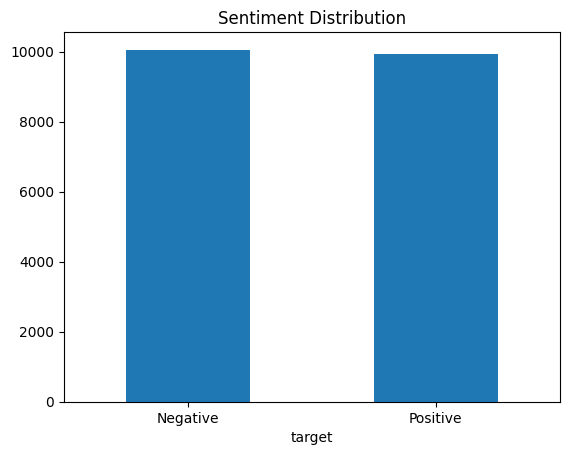

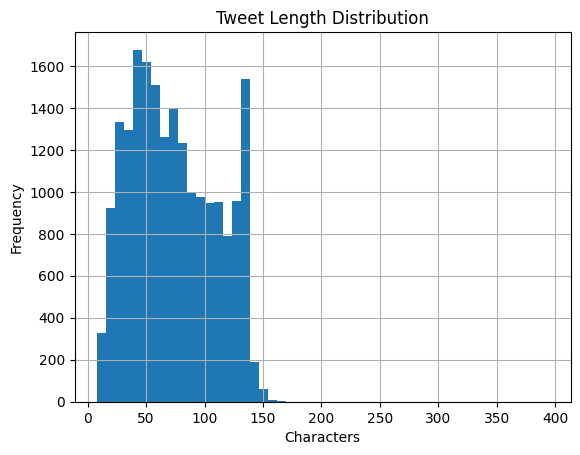

In [18]:
df['target'].value_counts().plot(kind='bar')
plt.title("Sentiment Distribution")
plt.xticks([0, 1], ["Negative", "Positive"], rotation=0)
plt.show()

df['text_length'] = df['text'].apply(len)
df['text_length'].describe()

df['text_length'].hist(bins=50)
plt.title("Tweet Length Distribution")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.show()

## Data Modeling

### Vectorize

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert text into numerical features
vectorizer = TfidfVectorizer(max_features=5000)  # limit vocab size for speed
X = vectorizer.fit_transform(df['cleaned_text']).toarray()
y = df['target']

### Test Split

In [21]:
df = df[df['cleaned_text'].str.strip() != ""]

# Check class counts
print(df['target'].value_counts())

# Rebuild X and y from the cleaned DataFrame
X = vectorizer.fit_transform(df['cleaned_text']).toarray()
y = df['target']

# Now split with stratify
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


target
1    9995
0    9897
Name: count, dtype: int64


### Naive Bayes

Naive Bayes Accuracy: 0.7235486303091229
              precision    recall  f1-score   support

    Negative       0.72      0.73      0.72      1980
    Positive       0.73      0.72      0.72      1999

    accuracy                           0.72      3979
   macro avg       0.72      0.72      0.72      3979
weighted avg       0.72      0.72      0.72      3979



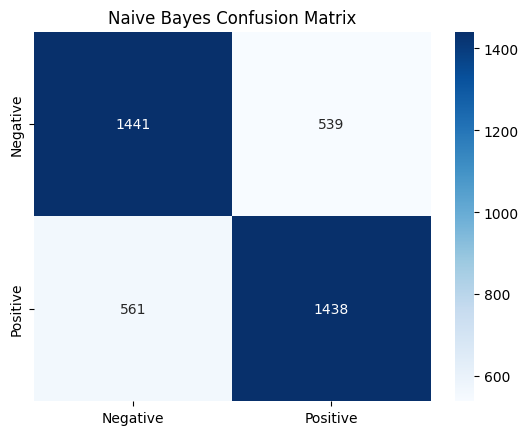

In [29]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predict
y_pred_nb = nb_model.predict(X_test)

# Evaluate
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb, target_names=["Negative", "Positive"]))

# Confusion matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.title("Naive Bayes Confusion Matrix")
plt.show()

### Logistic Regression

Logistic Regression Accuracy: 0.7245539080170897
              precision    recall  f1-score   support

    Negative       0.74      0.70      0.72      1980
    Positive       0.72      0.75      0.73      1999

    accuracy                           0.72      3979
   macro avg       0.73      0.72      0.72      3979
weighted avg       0.73      0.72      0.72      3979



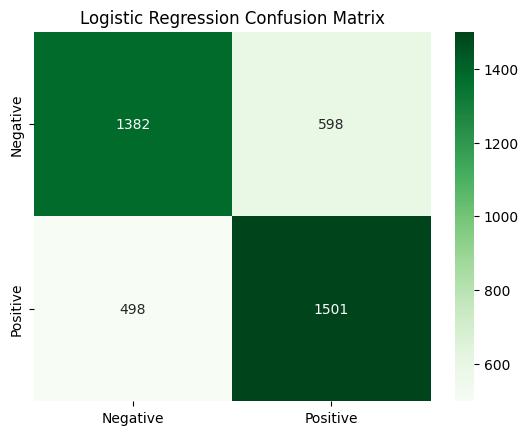

In [30]:
from sklearn.linear_model import LogisticRegression

# Train
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# Predict
y_pred_log = log_model.predict(X_test)

# Evaluate
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log, target_names=["Negative", "Positive"]))

# Confusion matrix
cm_log = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Greens',
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.title("Logistic Regression Confusion Matrix")
plt.show()

## Search For Specific Terms

In [ ]:
def search_and_analyze(term):
    # Filter tweets containing the term (case-insensitive)
    mask = df['cleaned_text'].str.contains(term, case=False, na=False)
    subset = df[mask]

    if subset.empty:
        print(f"No tweets found containing '{term}'.")
        return

    # Vectorize the subset
    X_subset = vectorizer.transform(subset['cleaned_text']).toarray()

    # Predict sentiment
    preds = model.predict(X_subset)

    # Add predictions to the subset DataFrame
    subset = subset.copy()
    subset['predicted_sentiment'] = preds
    subset['predicted_label'] = subset['predicted_sentiment'].map({0: "Negative", 1: "Positive"})

    # Show counts
    counts = subset['predicted_label'].value_counts()
    print(f"Sentiment for tweets containing '{term}':")
    print(counts)

    # Display sample tweets
    print("\nSample tweets:")
    for tweet, label in subset[['text', 'predicted_label']].head(5).values:
        print(f"[{label}] {tweet}")

    return subset

In [37]:
results_df = search_and_analyze("charlotte")

Sentiment for tweets containing 'charlotte':
predicted_label
Negative    3
Positive    3
Name: count, dtype: int64

Sample tweets:
[Negative] @ElleChanel want to shoot...but i'm not in charlotte .. 
[Positive] Dance Floor Anthem [I Don't Wanna Be In Love]  Good Charlotte &lt;33
[Negative] @catstein I'm sad I didn't get to see him in Charlotte the other night! I'm going to download that song I love though! I miss you 
[Negative]  Plane late 1.5 hrs. Wife &amp; I have 3 hr layover in Charlotte instead of 45 mins &amp; a drive from Wilmington SC to Myrtle Beach in the dark.
[Positive] @Rob_Hoffman I'll be at the show in Charlotte, NC on August 21. Really looking forward to it. 


In [38]:
import joblib

# Save the cleaned DataFrame
joblib.dump(df, "tweets_df.pkl")

# Save the vectorizer
joblib.dump(vectorizer, "vectorizer.pkl")

# Save the logistic regression model
joblib.dump(log_model, "logistic_regression.pkl")

['logistic_regression.pkl']